In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import itertools
import time
from tqdm import tqdm as tqdm
from copy import copy
from IPython.display import clear_output

from grid_env import GridEnvironment
from q_agent import Q_Agent

In [2]:
def plot_q_table(q_values):
    # Plot policy: 

    vmin = q_values.min()
    vmax = q_values.max()

    for flag_state in itertools.product(*[[1,0]]*n_flags):

        q_values_slice = q_values[get_slice(list(flag_state))]

        fig, axes = plt.subplots(2, 2, figsize=[5,5])
        fig.subplots_adjust(hspace=.3)
        for i, q, action in zip(range(4), q_values_slice.transpose(2,0,1), actions):
            ax = axes[i//2, i%2]
            im = ax.imshow(q, vmin=vmin, vmax=vmax)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(action.capitalize())

        cbar_ax = fig.add_axes([0.93, 0.125, 0.05, 0.755])
        fig.colorbar(im, cbar_ax)
        plt.suptitle(f'Flag State: {flag_state}', fontsize=14)
        plt.show()
        
        
def get_slice(flag_values: list):
    return tuple([slice(None),slice(None)]+flag_values+[slice(None),])

### Setup Environment and Agent

In [27]:
actions = ["up", "down", "left", "right"]

env_shape = (5,5)
shutdown_time = 60

# Exploration reward parameter:
beta = 0.1

# Q-Agent Parameters:
steps_to_decay = 8000
epsilon_decay=(0.1/0.9)**(1/steps_to_decay)

walls  = np.zeros(env_shape)
walls[((0,1,2,2,2,2,4), (1,3,0,1,2,3,2))] = 1

delays = {}
coins  = {(0,0):1, (4,1):1}

n_flags = len(delays) + len(coins)

agent = Q_Agent(env_shape, n_flags, actions, 
                discount_factor=0.9, epsilon_decay=epsilon_decay, learning_rate=0.25)

env = GridEnvironment(walls, delays, coins, beta=beta,
                      starting_pos=(4,4), env_shape=env_shape, 
                      shutdown_time=shutdown_time)

print(env)

C # . . . 
. . . # . 
# # # # . 
. . . . . 
. C # . A 



## Training Loop

In [28]:
episode_rewards = []
episode_histories = []

episodes = 10000

for episode in tqdm(range(episodes), position=0):
    
#     # randomly choose starting position
#     i = np.random.randint(0, np.sum(walls==0))
#     x, y = np.where(walls == 0)
#     env.starting_pos = (x[i], y[i])
    
    env.reset()
    
    done = False
    while not done:
        state = env.state
        action = agent.choose_action(state)
        old_state = copy(state)
        new_state, reward, done = env.step(action)
        agent.update_q_values(old_state, action, reward, new_state)
    
    episode_rewards.append(env.coins_collected)
    episode_histories.append(env.state_history)
    agent.update_epsilon()

100%|██████████| 10000/10000 [00:30<00:00, 329.77it/s]


## Visualize Agent Behavior:

### Heatmap of states visited

/Users/alexroman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


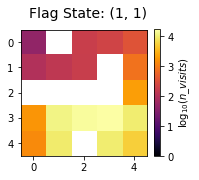

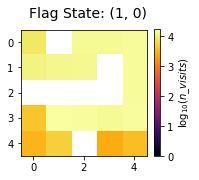

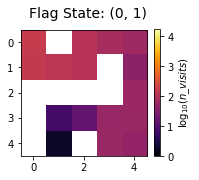

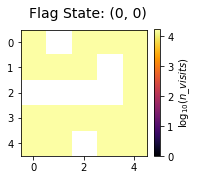

In [29]:
# Plot times visiting each state: 

vmax = (env.state_visit_counts.max())

for flag_state in itertools.product(*[[1,0]]*n_flags):
    visit_counts_slice = env.state_visit_counts[get_slice(list(flag_state))[:-1]]
    
    plt.figure(figsize=[2.5,2.5])
    plt.imshow(np.log10(visit_counts_slice), vmin=0, vmax=np.log10(vmax), cmap='inferno')
    plt.colorbar(label=r'$\log_{10}(n\_visits)$', fraction=0.0455, pad=0.05)
    plt.suptitle(f'Flag State: {flag_state}', fontsize=14)
    plt.show()

### Q-Table Visualization:

It is four-dimensional in the case of two flags, so we take spatial slices

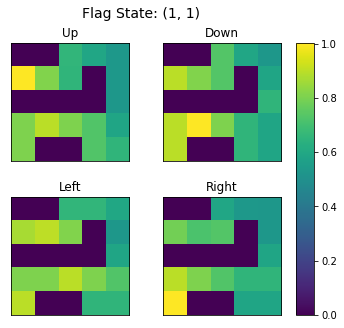

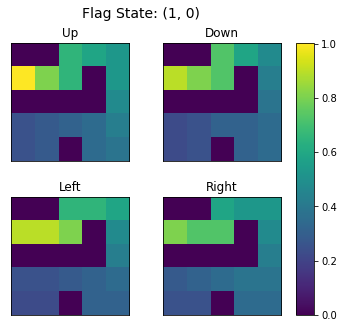

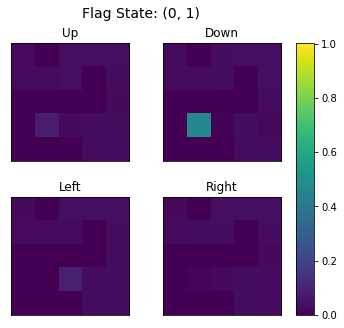

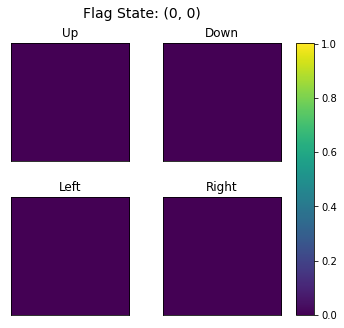

In [30]:
plot_q_table(agent.q_values)

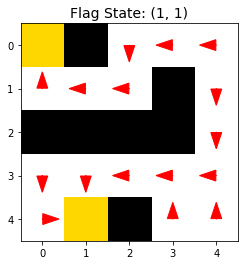

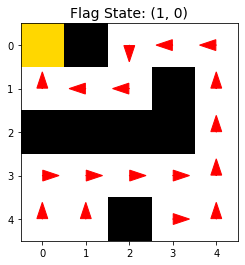

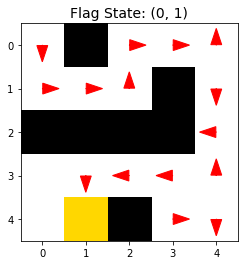

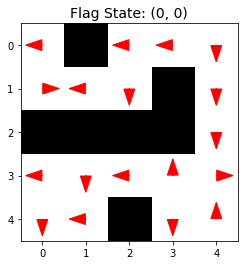

In [31]:
action_effects = {
    'up':    ( 0,-1),
    'down':  ( 0, 1),
    'left':  (-1, 0),
    'right': ( 1, 0)
    }

cmap = colors.ListedColormap(['white', 'blue', 'gold', 'green', 'pink', 'black'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = colors.BoundaryNorm(bounds, cmap.N)


for flag_state in itertools.product(*[[1,0]]*n_flags):

    q_values = agent.q_values[get_slice(list(flag_state))]
    
    im = walls*5
    for i in np.where(flag_state)[0]:
        im[list(coins.keys())[i]] = 2

    plt.imshow(im, cmap=cmap, norm=norm)
    # plt.axis('off')

    directions = np.argmax(q_values, 2)
    for row, col in zip(*np.where(im == 0)):
        if env.state_visit_counts[(row, col, *flag_state)]: # "if visited"
            plt.arrow(col,row,
                      *(np.array(action_effects[actions[directions[row,col]]])*.01),
                     head_width=.25, color='r')

    plt.title(f'Flag State: {flag_state}', fontsize=14)
    plt.show()

### Crude animation:

In [17]:
def deploy_agent():
    agent.epsilon = 0

    env.reset()
    done = False
    while not done:
        state = env.state
        action = agent.choose_action(state)
        old_state = copy(state)
        new_state, reward, done = env.step(action)

        time.sleep(0.5)
        print(action)
        print(env)
        clear_output(wait=True)
        
env.starting_pos = tuple(d-1 for d in env_shape)
deploy_agent()

up
A # . . . 
. . . # . 
# # # # . 
. . . . . 
. . # . . 



### Episode rewards over time:

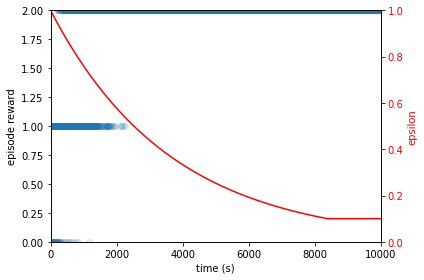

In [32]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('episode reward')
ax1.scatter(range(len(episode_rewards)), episode_rewards, alpha=.1)
ax1.tick_params(axis='y')
ax1.set_xlim(0, len(episode_rewards))
ax1.set_ylim(0, max(episode_rewards))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
inital_epsilon = 0.9
epsilon_history = np.maximum(agent.epsilon_decay**np.arange(len(episode_rewards)), agent.epsilon_min)
ax2.plot(epsilon_history, color='red')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

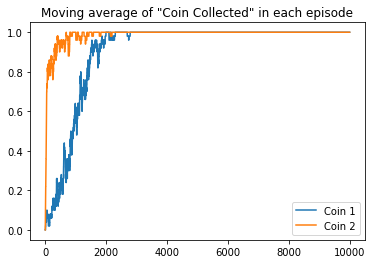

In [33]:
coin1_collected = [1-h[-1][2] for h in episode_histories]
coin2_collected = [1-h[-1][3] for h in episode_histories]

n = 50 # Period of moving average
plt.plot(np.convolve(coin1_collected, np.ones(n)/n)[:-n], label='Coin 1')
plt.plot(np.convolve(coin2_collected, np.ones(n)/n)[:-n], label='Coin 2')
plt.title('Moving average of "Coin Collected" in each episode')
plt.legend()
plt.show()